In [1]:
import boto3
import configparser
import os
import urllib3

import folium
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot

import tempfile

In [2]:
urllib3.disable_warnings()

### Connection with S3 Bucket
All GHSL datasets are available on S3 Bucket. Below configuration allows to list and download defined datasets from there.
There 6 GHSL products on bucket:
- GHS_BUILT_C
- GHS_BUILT_H
- GHS_BUILT_S
- GHS_BUILT_V
- GHS_POP
- GHS_SMOD

Useful links
- https://human-settlement.emergency.copernicus.eu/download.php

In [3]:
def s3_connection(credentials: dict) -> boto3.session.Session:
    """Establishes a connection to an S3 bucket.

    Args:
        credentials (dict): A dictionary containing AWS S3 credentials with keys 
                            'host_base', 'access_key', and 'secret_key'.

    Returns:
        boto3.session.Session: A boto3 session client configured with the provided 
                               credentials for interacting with the S3 service.
    """
    s3 = boto3.client('s3',
                      endpoint_url=credentials['host_base'],
                      aws_access_key_id=credentials['access_key'],
                      aws_secret_access_key=credentials['secret_key'],
                      use_ssl=True,
                      verify=False)
    return s3

# Load s3 credentials
config = configparser.ConfigParser()
config.read('/home/eouser/.s3cfg')
credentials = dict(config['default'].items())

# Connection with S3 eodata
s3 = s3_connection(credentials)

### Browsing S3 bucket content
**Prefix** parameter is used to defining which datasets user would like to find on S3 bucket

In [4]:
# Listing all GHS_BUILT_S data for year 2020 and spatial resolution 100m
response = s3.list_objects_v2(Bucket='ESTAT', Prefix='GHSL/GHS_BUILT_S/2020/100m')

In [5]:
if 'Contents' in response:
    print("Objects in bucket:")
    # Iterate over each object
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No objects found in the bucket.")

Objects in bucket:
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R11_C23.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R12_C24.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R1_C19.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R1_C20.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R2_C17.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R2_C18.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R2_C19.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R2_C20.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R2_C21.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R3_C18.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0_R3_C19.tif
GHSL/GHS_BUILT_S/2020/100m/GHS_BUILT_S_E2020_GLOBE_R202

In [6]:
# Listing all GHS_BUILT_S data for year 2020 and all spatial resolutions
response = s3.list_objects_v2(Bucket='ESTAT', Prefix='GHSL/GHS_BUILT_S/2020')

In [7]:
if 'Contents' in response:
    print("Objects in bucket:")
    # Iterate over each object
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No objects found in the bucket.")

Objects in bucket:
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R11_C23.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R12_C24.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R1_C19.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R1_C20.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R2_C17.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R2_C18.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R2_C19.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R2_C20.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R2_C21.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C18.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19.tif
GHSL/GHS_BUILT_S/2020/1000m/GHS_B

### Reading vector file to GeoDataFrame

In [8]:
object_path = 'GHSL/TILES/GHSL_tiles_Europe_4326.gpkg'

# Create a temporary directory to store GeoPackage file
with tempfile.TemporaryDirectory() as tmpdirname:
    # Define local path to save GeoPackage file
    local_geopackage_path = os.path.join(tmpdirname, object_path.split('/')[-1])

    # Download the GeoPackage from S3
    s3.download_file('ESTAT', object_path, local_geopackage_path)

    # Read the GeoPackage into a GeoDataFrame
    gdf = gpd.read_file(local_geopackage_path)

In [9]:
# Geodata parameters
print(gdf.info())
print('----')
print(f'Coordinate system: {gdf.crs}')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tile_id   41 non-null     object  
 1   left      41 non-null     float64 
 2   top       41 non-null     float64 
 3   right     41 non-null     float64 
 4   bottom    41 non-null     float64 
 5   geometry  41 non-null     geometry
dtypes: float64(4), geometry(1), object(1)
memory usage: 2.0+ KB
None
----
Coordinate system: EPSG:4326


In [10]:
gdf.head()

,tile_id,left,top,right,bottom,geometry
0,R7_C12,-70.007916,29.099583,-60.007916,19.099583,"POLYGON ((-60.00792 29.09958, -60.00792 19.099..."
1,R8_C12,-70.007916,19.099583,-60.007916,9.099583,"POLYGON ((-60.00792 19.09958, -60.00792 9.0995..."
2,R8_C13,-60.007916,19.099583,-50.007916,9.099583,"POLYGON ((-50.00792 19.09958, -50.00792 9.0995..."
3,R9_C13,-60.007916,9.099583,-50.007916,-0.900416,"POLYGON ((-50.00792 9.09958, -50.00792 -0.9004..."
4,R5_C15,-40.007916,49.099583,-30.007917,39.099583,"POLYGON ((-30.00792 49.09958, -30.00792 39.099..."


### GeoDataFrame explanation

GeoDataFrame inherits most of pandas DataFrame methods. That allows to work with GeoDataFrame on the same way. 

In [11]:
# Creating new GeoDataFrame with defined columns
gdf[gdf.tile_id == 'R7_C12']

,tile_id,left,top,right,bottom,geometry
0,R7_C12,-70.007916,29.099583,-60.007916,19.099583,"POLYGON ((-60.00792 29.09958, -60.00792 19.099..."


### Displaying geometries on basemap

To display vector geometry on map we recommend folium. Folium allows displaying different types of geometries like Polygons, Lines and Points. <br>
IMPORTANT: Each geometry presenting on map must be transformed to EPSG:4326 coordinates system

In [12]:
# Add the polygons to the map

m1 = folium.Map(location=[30.0, 0.0], zoom_start=2)

for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["tile_id"]).add_to(geo_j)
    geo_j.add_to(m1)

m1

### Reading raster file
Geographic information systems use GeoTIFF and other formats to organize and store gridded, or raster, datasets. Rasterio reads and writes these formats and provides a Python API based on N-D arrays. <br>
More information: https://rasterio.readthedocs.io/en/stable/quickstart.html

In [13]:
# S3 reference to GeoTIFF
object_path = 'GHSL/GHS_BUILT_S/2020/3ss/GHS_BUILT_S_E2020_GLOBE_R2023A_4326_3ss_V1_0_R5_C19.tif'

# Create a temporary directory to store the raster file
with tempfile.TemporaryDirectory() as tmpdirname:
    # Define local path to save raster file
    local_raster_path = os.path.join(tmpdirname, object_path.split('/')[-1])

    # Download raster from S3
    s3.download_file('ESTAT', object_path, local_raster_path)

    # Read raster into numpy array
    with rasterio.open(local_raster_path) as src:
        raster_data = src.read()
        raster_metadata = src.meta

In [14]:
# Printing metadata

print(src.meta) # Raster total metadata
print('---')
print(src.width, src.height) # Numner of rows and columns in raster
print(src.crs) # Coordinate system
print(src.transform) # Parameters of affine transformation
print(src.count) # Number of bands

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0008333333300326821, 0.0, -0.00791664424099281,
       0.0, -0.0008333333299795073, 49.09958333862926)}
---
12000 12000
EPSG:4326
| 0.00, 0.00,-0.01|
| 0.00,-0.00, 49.10|
| 0.00, 0.00, 1.00|
1


In [15]:
# Raster data is read as numpy array
print(type(raster_data))
print(raster_data.shape)
raster_data

<class 'numpy.ndarray'>
(1, 12000, 12000)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

### Plotting raster file
There are couple of options to plot raster file. Below we present most popular option using matplotlib.pyplot module and tool implemented in rasterio package.
More information:
- https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html
- https://rasterio.readthedocs.io/en/stable/topics/plotting.html

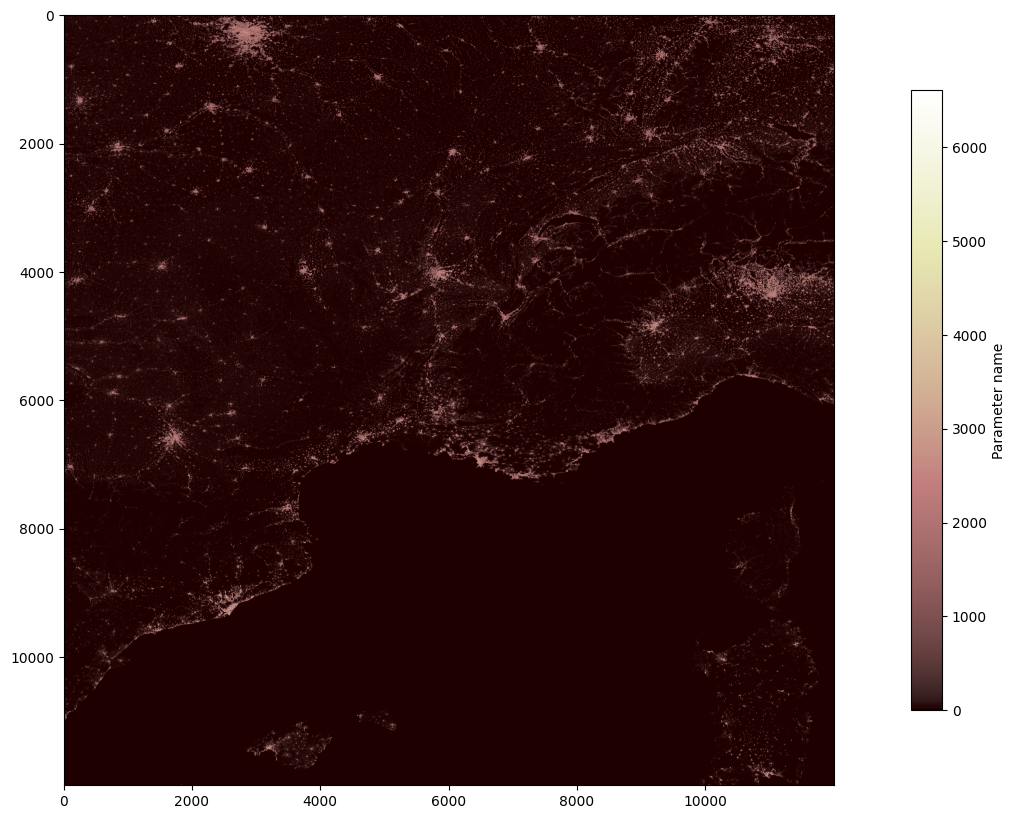

In [16]:
# Plotting definition
fig, ax = pyplot.subplots(1, figsize=(20,10))

# Plotting raster
pyplot.imshow(raster_data[0], cmap='pink')

# Plotting color bar
pyplot.colorbar(label='Parameter name', fraction=0.02, ax=ax)

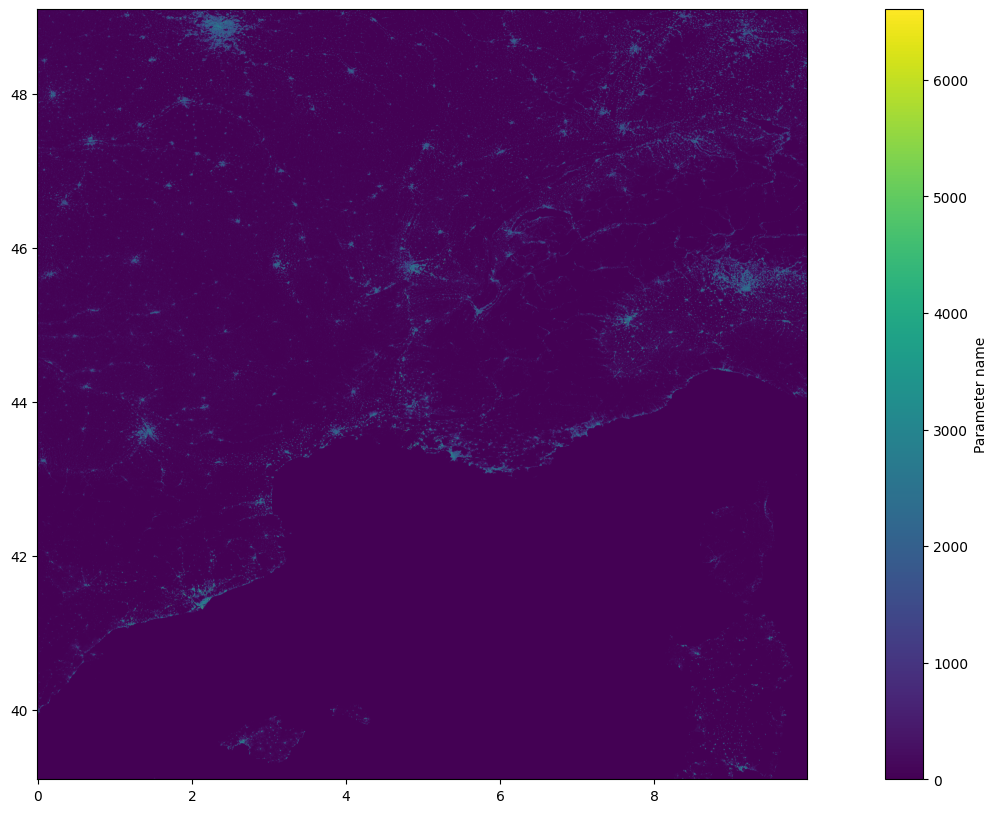

In [17]:
# Rasterio also provides rasterio.plot.show() to perform common tasks such as displaying 
# multi-band images as RGB and labeling the axes with proper geo-referenced extents.

# Plotting definition
fig, ax = pyplot.subplots(1, figsize=(20,10))

# Plotting raster with georeference
rs = show(raster_data[0], ax=ax, transform=src.transform)

# Plotting color bar
fig.colorbar(rs.get_images()[0], ax=ax, label='Parameter name')